In [4]:
# Packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from scipy import stats

In [2]:
# Func that assign location id
def spatial_token(x, y):
    return (x-1)+(y-1)*200

In [3]:
# Import relevant data
yjmob1_df = pd.read_csv('yjmob100k-dataset1.csv.gz', compression='gzip')
poi_description = pd.read_csv('POI_datacategories.csv', header=None)
poi_df = pd.read_csv('cell_POIcat.csv.gz', compression='gzip')

# Assign location id to each (x,y) location
yjmob1_df['combined_xy'] = yjmob1_df.apply(lambda row: spatial_token(row['x'], row['y']), axis=1)
poi_df['combined_xy'] = poi_df.apply(lambda row: spatial_token(row['x'], row['y']), axis=1)

# Match with the poi_df index with the poi_description
poi_df['POIcategory'] = poi_df['POIcategory']-1

<Axes: >

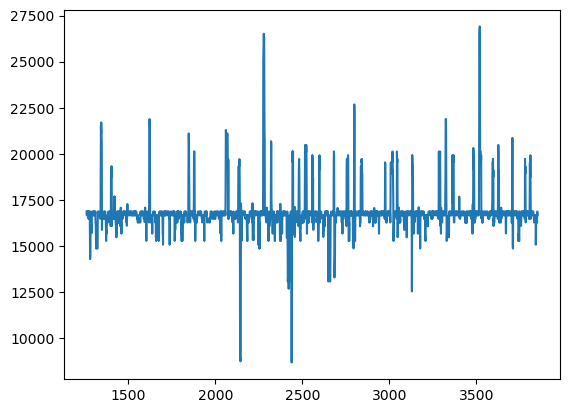

In [11]:
# Time-Series proposed
yjmob1_df[yjmob1_df['uid']==1]['combined_xy'].plot() # a series (disregard timestamp for simplicity)

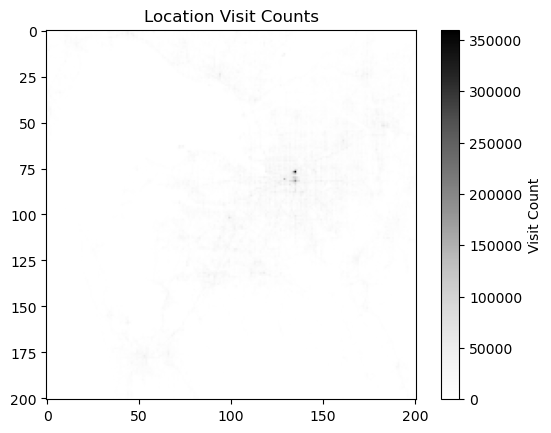

In [18]:
# Examine Visit Count
loc_frequency = yjmob1_df.groupby(['x', 'y']).size().reset_index(name='visit_count')

# Create an empty matrix for heatmap visualization
max_x = loc_frequency['x'].max()+1
max_y = loc_frequency['y'].max()+1
heatmap_matrix = np.zeros((max_y, max_x))

# Fill the matrix with visit_count
for _, row in loc_frequency.iterrows():
    heatmap_matrix[row['y'], row['x']] = row['visit_count']

# Display Heatmap
plt.imshow(heatmap_matrix, cmap='Greys')
plt.colorbar(label='Visit Count')
plt.title('Location Visit Counts')
plt.show()

In [20]:
display(loc_frequency.sort_values('visit_count', ascending=False))

,x,y,visit_count
21837,135,77,359963
21842,135,82,196083
21651,134,77,176167
20744,129,81,151722
21838,135,78,140375
...,...,...,...
28277,170,113,1
28275,170,111,1
28274,170,110,1
28270,170,106,1


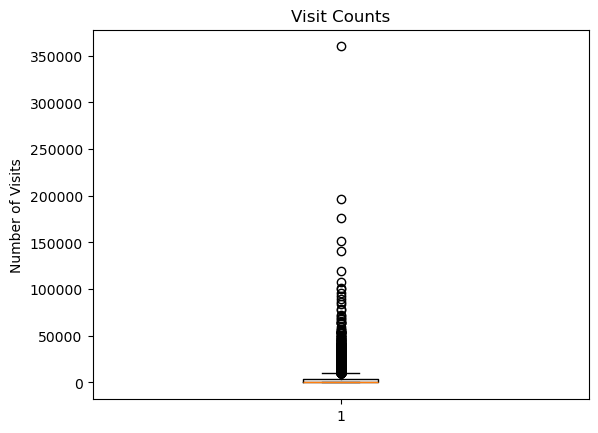

In [60]:
# Box-plot: visit count
plt.boxplot(loc_frequency.sort_values('visit_count')['visit_count'])
plt.title('Visit Counts')
plt.ylabel('Number of Visits')
plt.show()

Text(0, 0.5, 'Visit Count')

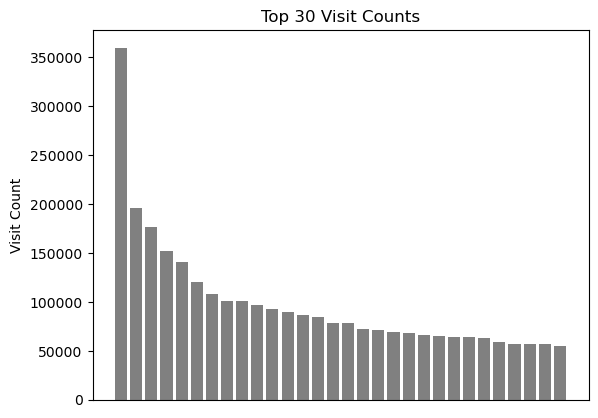

In [44]:
plt.bar([i for i in range(30)], loc_frequency.sort_values('visit_count', ascending=False).head(30)['visit_count'], color='grey')
plt.xticks([]) # remove x-ticks
plt.title('Top 30 Visit Counts')
plt.ylabel('Visit Count')

In [64]:
# Set up metrices in mobility

# Entropy - predictability of the movement (i.e., randomness)
def entropy(user_df):
    location_counts = user_df['combined_xy'].value_counts()
    probabilities = location_counts / location_counts.sum()
    return -np.sum(probabilities * np.log2(probabilities))

# Radius of Gyradtion - how explorer
def radius_of_gyration(user_df):
    user_df['x'] = user_df['x'].astype(float)
    user_df['y'] = user_df['y'].astype(float)
    center_of_mass_x = user_df['x'].mean()
    center_of_mass_y = user_df['y'].mean()
    user_df['distance_from_cm'] = np.sqrt((user_df['x'] - center_of_mass_x)**2 + (user_df['y'] - center_of_mass_y)**2)
    return np.sqrt((user_df['distance_from_cm']**2).mean())

# Count_Unique_Visits - How many unique places has one been to

# Stay Measure - How often user visits/stay in the same location (potential home location)

# Average Speed of Movement (are there potential car drivers?)
def temporal_token(df):
    return df['d'] * 48 + df['t']

def calculate_distances(df):
    # Calculate Euclidean distances between consecutive points
    distances = np.sqrt(np.diff(df['x'], append=df['x'].iloc[-1])**2 + np.diff(df['y'], append=df['y'].iloc[-1])**2)
    return distances[:-1]

def calculate_speeds(df):
    total_time_units = temporal_token(df)
    time_deltas = np.diff(total_time_units, append=total_time_units.iloc[-1])  # Time differences
    distances = calculate_distances(df)
    speeds = distances / time_deltas[:-1]
    return speeds

def average_speed(user_df):
    speeds = calculate_speeds(user_df)
    return np.nanmean(speeds)

# Available Movement Data (how many times user open phones w/ location recorded)

# Aggregate Results
analysis = yjmob1_df.groupby('uid').apply(lambda x: pd.Series({
    'Count_Unique_Visits': x['combined_xy'].nunique(),
    'Stay_Measure': x['combined_xy'].value_counts().max(),
    'Count_Available_Data': x['combined_xy'].count(),
    'Average_Speed_Measure': average_speed(x),
    'Radius_of_Gyration': radius_of_gyration(x),
    'Entropy': entropy(x)
}))

/var/folders/hx/xp23lpqx4ndfxcvp3qj_bdgr0000gn/T/ipykernel_27487/1040619755.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  analysis = yjmob1_df.groupby('uid').apply(lambda x: pd.Series({


In [65]:
analysis.head(3)

,Count_Unique_Visits,Stay_Measure,Count_Available_Data,Average_Speed_Measure,Radius_of_Gyration,Entropy
uid,,,,,,
0,409.0,127.0,1261.0,7.282189,19.486283,7.343733
1,315.0,538.0,2592.0,3.471649,16.457995,5.152022
2,89.0,363.0,1044.0,2.099558,9.855459,3.454961


,Count_Unique_Visits,Stay_Measure,Count_Available_Data,Average_Speed_Measure,Radius_of_Gyration,Entropy
Count_Unique_Visits,1.000000,-0.394396,0.093807,0.668601,0.634747,0.840464
Stay_Measure,-0.394396,1.000000,0.651288,-0.431414,-0.386518,-0.746841
Count_Available_Data,0.093807,0.651288,1.000000,-0.140577,-0.150428,-0.252539
Average_Speed_Measure,0.668601,-0.431414,-0.140577,1.000000,0.773794,0.680633
Radius_of_Gyration,0.634747,-0.386518,-0.150428,0.773794,1.000000,0.606429
Entropy,0.840464,-0.746841,-0.252539,0.680633,0.606429,1.000000


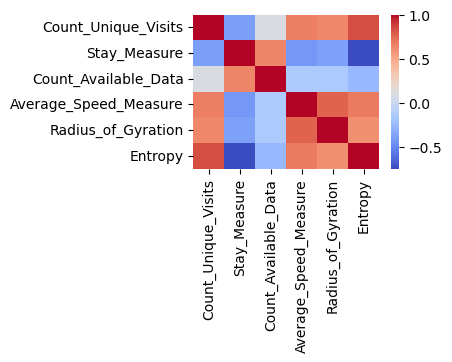

In [79]:
display(analysis.corr())

plt.figure(figsize=(3, 2))
sns.heatmap(analysis.corr(), cmap='coolwarm')
plt.show()

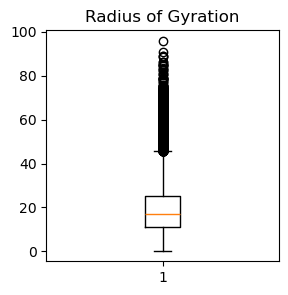

In [81]:
# Box-plot: Radius of gyration
plt.figure(figsize=(3, 3))
plt.boxplot(analysis['Radius_of_Gyration'])
plt.title('Radius of Gyration')
plt.show()

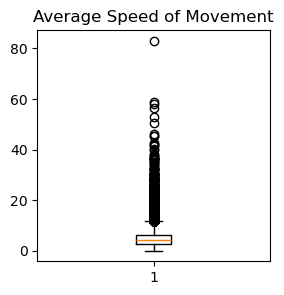

In [82]:
# Box-plot: Average speed of movement
plt.figure(figsize=(3, 3))
plt.boxplot(analysis['Average_Speed_Measure'])
plt.title('Average Speed of Movement')
plt.show()

Explained Variance: [0.59621841 0.23124984]


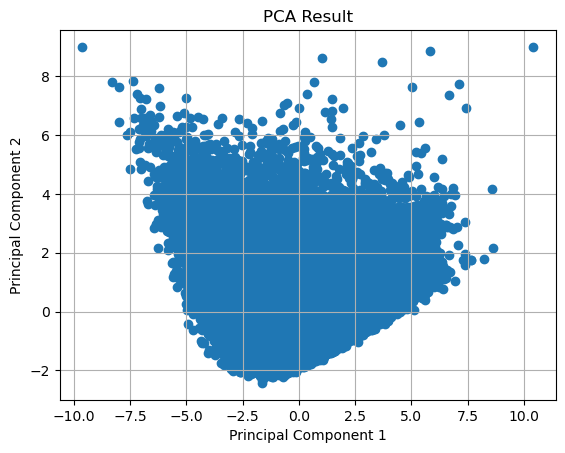

In [84]:
# Very basic data dimension reduction
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = analysis.values

# Standardization / Normalization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
print("Explained Variance:", pca.explained_variance_ratio_)

# Plot the PCA results
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Result')
plt.grid(True)
plt.show()

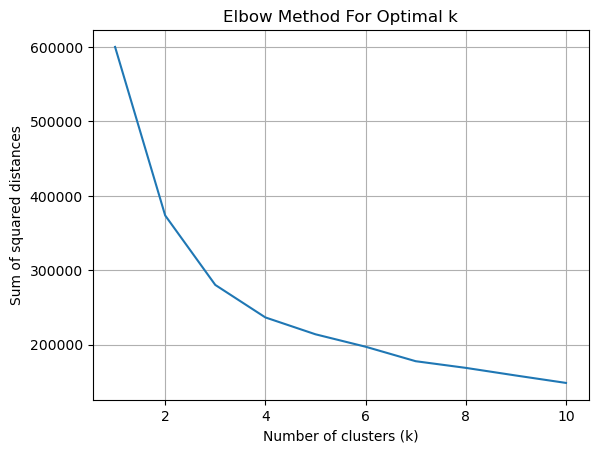

In [88]:
# User Clustering based on Mobility Traits - K-Means
from sklearn.cluster import KMeans

# Extract values
X = analysis.values

# Standardization / Normalization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply Elbow method
ssd = []
K_range = range(1, 11) 
for k in range(1, 11) :
    kmeans = KMeans(n_clusters=k, random_state=123)
    kmeans.fit(X_scaled)
    ssd.append(kmeans.inertia_)

# Plot SSDs for each k
plt.plot(K_range, ssd)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()

In [90]:
# Clustering with k-means with 4 classes
kmeans = KMeans(n_clusters=4, random_state=123)
clusters = kmeans.fit_predict(X_pca)

# Classify users
analysis['Cluster'] = clusters

# Analyze cluster centroids (for user characteristics)
centroids = scaler.inverse_transform(pca.inverse_transform(kmeans.cluster_centers_))
pd.DataFrame(centroids, columns=analysis.columns[:-1]) # not including Cluster column

,Count_Unique_Visits,Stay_Measure,Count_Available_Data,Average_Speed_Measure,Radius_of_Gyration,Entropy
0,387.887568,117.198984,1174.624894,9.950080,35.640807,7.340459
1,124.194305,298.168663,1003.095727,2.920721,12.668935,4.481894
2,231.195446,167.239760,960.708707,5.954815,22.539485,5.829822
3,146.743418,651.794066,1736.702246,2.355179,11.108591,3.519547


In [57]:
# Checks
if (len(poi_df['POIcategory'].unique())-1 == sorted(poi_df['POIcategory'].unique())[-1]):
    print("All POIs are captured")

All POIs are captured


In [ ]:
# Collinearity among POIs

In [ ]:
# ANOVA among POIs

In [ ]:
# Heatmap on Shopping POI

In [ ]:
# Can POI help account for Visit counts

# Thought: Use POI visit count embedding > All visit count embedding - smaller number, smaller scale

In [ ]:
# Which POI to use (Finalized)

In [ ]:
# DBSCAN - User Clustering based on selected POI and selected Mobility Traits

In [ ]:
# XGBoost

In [ ]:
# Accuracy

# Precision

# Recall

#### Old Code (MLR)

In [243]:
X = data[data.columns[data.columns.isin(significant_poi.keys())]]
Y = data['visit_count']

X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            visit_count   R-squared:                       0.713
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     4218.
Date:                Fri, 21 Jun 2024   Prob (F-statistic):               0.00
Time:                        20:19:53   Log-Likelihood:            -3.2488e+05
No. Observations:               34032   AIC:                         6.498e+05
Df Residuals:                   34011   BIC:                         6.500e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   820.68

### Random Thoughts

1. For each range of time
2. For all location
3. Caculate the average stay time (outlier can be considerate)
4. Calculate the corresponding POI category and POI count there
5. time: poi_category | poi_count | average_duration_of_stay

```
# time: 0
data_by_time = [time_group for t,time_group in yjmob1_df.groupby('t')][0]

for combined_xy,loc_group in data_by_time[0].groupby('combined_xy'):
    print([0, combined_xy, len(loc_group['uid'].unique())])

# location: 0
data_by_loc = [loc_group for loc,loc_group in yjmob1_df.groupby('combined_xy')][0]

# time: 8AM-10PM
total_people = 0
total_stay_time = 0
for uid, uid_group in data_by_loc[(data_by_loc['t']>=8*2) & (data_by_loc['t']<10*2)].groupby('uid'):
    total_people += 1
    total_stay_time += uid_group['t'].max() - uid_group['t'].min()
    
# average stay time
print(total_stay_time, total_people, total_stay_time/total_people)

# corresponding POIcategory and POI_count
display(poi_df[poi_df['combined_xy']==0][['POIcategory','POI_count']])
```